# Activation maximization
In this task, we use the approach of activation maximization to visualize to which patterns features of a CNN trained using on MNIST are sensitive. This will give us a deeper understanding of the working principle of CNNs.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

KTF = keras.backend
layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


### Get and preprocess data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


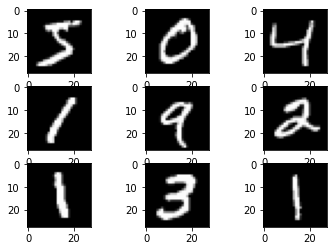

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = keras.datasets.mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)[...,np.newaxis] / 255.
x_test = x_test.astype(np.float32)[...,np.newaxis] / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [5]:
x_train.shape

(60000, 28, 28, 1)

### Set up a convolutional neural network with at least 4 CNN layers.

In [20]:
model = keras.models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='conv2d_1'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2d_3'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2d_4'),
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10),
    layers.Activation('softmax', name='softmax_layer')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)               

### Compile and train the model

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy'])


results = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1
                    )

Epoch 1/3
540/540 [==============================] - 50s 92ms/step - loss: 0.5653 - accuracy: 0.8175 - val_loss: 0.0820 - val_accuracy: 0.9773
Epoch 2/3
540/540 [==============================] - 47s 88ms/step - loss: 0.1929 - accuracy: 0.9415 - val_loss: 0.0580 - val_accuracy: 0.9855
Epoch 3/3
540/540 [==============================] - 55s 102ms/step - loss: 0.1483 - accuracy: 0.9548 - val_loss: 0.0449 - val_accuracy: 0.9880


### Implementation of activation maximization
Select a layer you want to visualize and perform activation maximization.

In [22]:
gradient_updates = 50
step_size = 1.

def normalize(x):
    '''Normalize gradients via l2 norm'''
    return x / (KTF.sqrt(KTF.mean(KTF.square(x))) + KTF.epsilon())


In [23]:
#layer_output.shape

In [27]:
visualized_feature = []
layer_dict = dict([(layer.name, layer) for layer in model.layers[:]])
layer_name = "conv2d_4"

layer_output = layer_dict[layer_name].output
sub_model = keras.models.Model([model.inputs], [layer_output])

for filter_index in range(layer_output.shape[-1]):

    print('Processing feature map %d' % (filter_index+1))
    # activation maximization
    input_img = KTF.variable(np.zeros((1, 28, 28, 1)))
    for i in range(gradient_updates):

        with tf.GradientTape() as gtape:

            layer_output = sub_model(input_img)
            f = KTF.mean(layer_output[..., filter_index])  # f
            grads = gtape.gradient(f, input_img)
            grads = normalize(grads)
            input_img.assign_add(step_size * grads)

    visualized_feature.append(input_img.numpy())  # cast to numpy array

Processing feature map 1
Processing feature map 2
Processing feature map 3
Processing feature map 4
Processing feature map 5
Processing feature map 6
Processing feature map 7
Processing feature map 8
Processing feature map 9
Processing feature map 10
Processing feature map 11
Processing feature map 12
Processing feature map 13
Processing feature map 14
Processing feature map 15
Processing feature map 16
Processing feature map 17
Processing feature map 18
Processing feature map 19
Processing feature map 20
Processing feature map 21
Processing feature map 22
Processing feature map 23
Processing feature map 24
Processing feature map 25
Processing feature map 26
Processing feature map 27
Processing feature map 28
Processing feature map 29
Processing feature map 30
Processing feature map 31
Processing feature map 32
Processing feature map 33
Processing feature map 34
Processing feature map 35
Processing feature map 36
Processing feature map 37
Processing feature map 38
Processing feature ma

#### Plot images to visualize to which patterns the respective feature maps are sensitive.

In [28]:
def deprocess_image(x):
    # reprocess visualization to format of "MNIST images"
    x -= x.mean()
    x /= (x.std() + KTF.epsilon())
    # x *= 0.1
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

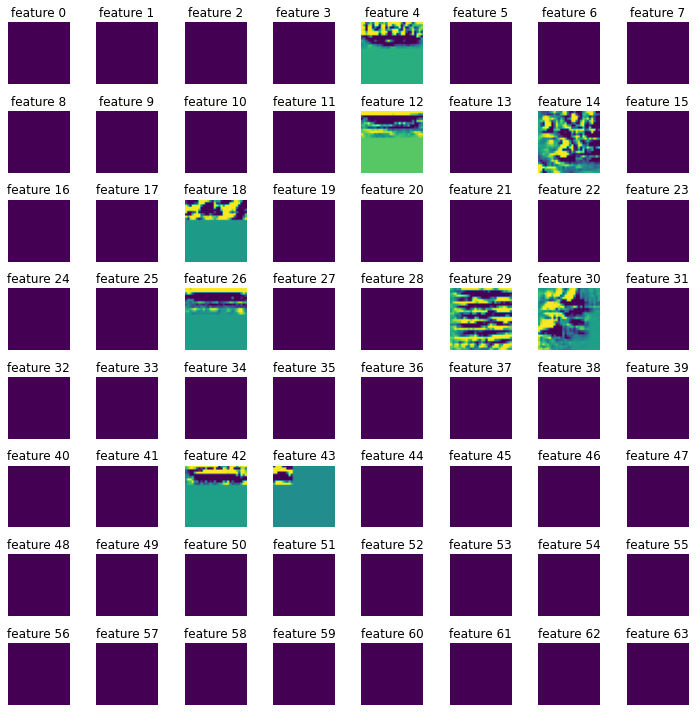

In [29]:
plt.figure(figsize=(10,10))

for i, feature_ in enumerate(visualized_feature):
    feature_image = deprocess_image(feature_)
    ax = plt.subplot(8, 8, 1+i)
    plt.imshow(feature_image.squeeze())
    ax.axis('off')
    plt.title("feature %s" % i)
    
plt.tight_layout()